In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pickle
BASE_PATH = "/kaggle/input/cifar-wec/cifar-10-batches-py"

train_data = []
train_label = []

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict
        
for i in range(1,6):
    batch_path = os.path.join(BASE_PATH , f"data_batch_{i}" )
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_label.extend(batch[b'labels'])

X_train = np.vstack(train_data)      
y_train = np.array(train_label)     

In [3]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(batch[b'data'])
test_label.extend(batch[b'labels'])

y_test = np.array(test_label)    

In [4]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [5]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

In [6]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

train_data_flat = np.vstack(train_data)
test_data_flat = np.vstack(test_data)   

train_images = cifar_dataset_to_pil(train_data_flat)
test_images = cifar_dataset_to_pil(test_data_flat)

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import multiprocessing

class CIFAR10_dataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.has_labels = labels is not None
        print(f"\nLoading CIFAR10 Dataset... Total Len: {len(images)} | Labeled: {self.has_labels}\n{'-'*50}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        if self.has_labels:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"img": img, "label": label}
        else:
            return {"img": img}


train_images_split, val_images, y_train_split, y_val = train_test_split(
    train_images, y_train,
    test_size=0.2,         
    random_state=42,       
    stratify=y_train        
)

In [8]:
train_dataset = CIFAR10_dataset(train_images_split, y_train_split, transform=train_transform)
val_dataset = CIFAR10_dataset(val_images, y_val, transform=test_transform)
test_dataset = CIFAR10_dataset(test_images, labels=None, transform=test_transform)

batch_size = 128 # 128 per GPU if 2 GPUs
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)



Loading CIFAR10 Dataset... Total Len: 40000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: False
--------------------------------------------------


In [9]:
def create_model(model_name, num_classes=10):
    if model_name == 'ResNet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'VGG16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    
    return model

In [10]:
model_configs = {
    "ResNet18": {
        "optimizer": "SGD",
        "lr": 0.01,
        "momentum": 0.8,
        "weight_decay": 5e-4
    },
    "EfficientNet-B0": {
        "optimizer": "AdamW",
        "lr": 0.001,
        "weight_decay": 1e-4
    },
    "VGG16": {
        "optimizer": "AdamW",
        "lr": 0.0005,
        "momentum": 0.9,
        "weight_decay": 5e-4
    }
}


In [11]:
import os

os.makedirs("/kaggle/working/model_results", exist_ok=True)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import os
import numpy as np

def train_model(model, model_name, train_loader, val_loader, epochs=50):
    print(f"Training {model_name}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # ===== MULTI-GPU SUPPORT =====
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel!")
        model = nn.DataParallel(model)
    model = model.to(device)

    # ===== MIXED PRECISION SETUP =====
    scaler = GradScaler()

    # ===== OPTIMIZER SETUP =====
    config = model_configs[model_name]
    if config['optimizer'] == 'SGD':
        optimizer = optim.SGD(
            model.parameters(),
            lr=config['lr'],
            weight_decay=1e-4,
            momentum=config.get('momentum', 0.8)
        )
    else:
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.1, patience=5, min_lr=1e-5
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0
    best_model_path = f"/kaggle/working/model_results/best_{model_name.replace('-', '_')}.pth"

    for epoch in range(epochs):
        # ===== TRAINING PHASE =====
        model.train()
        train_loss, train_correct = 0.0, 0

        for batch in tqdm(train_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs} [Train]'):
            images, labels = batch["img"].to(device), batch["label"].to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # ===== VALIDATION PHASE =====
        model.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs} [Val]'):
                images, labels = batch["img"].to(device), batch["label"].to(device)

                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)

        # ===== LOGGING =====
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"\n{model_name} - Epoch {epoch+1}/{epochs}")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

        # ===== SAVE BEST MODEL =====
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"NEW BEST MODEL! Val Acc: {val_acc:.2f}%")

        lr_scheduler.step(val_loss)

    print(f"\n {model_name} Training Complete! Best Val Acc: {best_val_acc:.2f}%")
    return history, best_val_acc


In [13]:
all_results = {}

for model_name in model_configs.keys():
    # Create the model
    model = create_model(model_name, num_classes=10)
    
    # Train the model
    history, best_acc = train_model(model, model_name, train_loader, val_loader, epochs=50)
    
    # Store results
    all_results[model_name] = {
        'history': history,
        'best_val_acc': best_acc
    }
    
    print(f"{model_name} training complete. Best Val Acc: {best_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]
/tmp/ipykernel_37/3710214293.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training ResNet18


ResNet18 - Epoch 1/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_37/3710214293.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
ResNet18 - Epoch 1/50 [Val]:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_37/3710214293.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
ResNet18 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 65.35it/s]



ResNet18 - Epoch 1/50
   Train Loss: 1.3392 | Train Acc: 52.38%
   Val Loss:   0.9283 | Val Acc:   67.62%
NEW BEST MODEL! Val Acc: 67.62%


ResNet18 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.71it/s]



ResNet18 - Epoch 2/50
   Train Loss: 1.0013 | Train Acc: 65.21%
   Val Loss:   0.7809 | Val Acc:   72.85%
NEW BEST MODEL! Val Acc: 72.85%


ResNet18 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.85it/s]



ResNet18 - Epoch 3/50
   Train Loss: 0.8877 | Train Acc: 69.20%
   Val Loss:   0.7181 | Val Acc:   75.37%
NEW BEST MODEL! Val Acc: 75.37%


ResNet18 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.39it/s]



ResNet18 - Epoch 4/50
   Train Loss: 0.8151 | Train Acc: 71.79%
   Val Loss:   0.6881 | Val Acc:   76.53%
NEW BEST MODEL! Val Acc: 76.53%


ResNet18 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.89it/s]



ResNet18 - Epoch 5/50
   Train Loss: 0.7679 | Train Acc: 73.19%
   Val Loss:   0.6004 | Val Acc:   79.55%
NEW BEST MODEL! Val Acc: 79.55%


ResNet18 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.89it/s]



ResNet18 - Epoch 6/50
   Train Loss: 0.7241 | Train Acc: 74.67%
   Val Loss:   0.6189 | Val Acc:   78.47%


ResNet18 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 74.80it/s]



ResNet18 - Epoch 7/50
   Train Loss: 0.7001 | Train Acc: 75.54%
   Val Loss:   0.5983 | Val Acc:   79.49%


ResNet18 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.47it/s]



ResNet18 - Epoch 8/50
   Train Loss: 0.6710 | Train Acc: 76.67%
   Val Loss:   0.5786 | Val Acc:   79.55%


ResNet18 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.79it/s]



ResNet18 - Epoch 9/50
   Train Loss: 0.6503 | Train Acc: 77.41%
   Val Loss:   0.5824 | Val Acc:   80.12%
NEW BEST MODEL! Val Acc: 80.12%


ResNet18 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.58it/s]



ResNet18 - Epoch 10/50
   Train Loss: 0.6288 | Train Acc: 78.03%
   Val Loss:   0.5429 | Val Acc:   81.23%
NEW BEST MODEL! Val Acc: 81.23%


ResNet18 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 74.00it/s]



ResNet18 - Epoch 11/50
   Train Loss: 0.6135 | Train Acc: 78.62%
   Val Loss:   0.5698 | Val Acc:   80.32%


ResNet18 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.03it/s]



ResNet18 - Epoch 12/50
   Train Loss: 0.5939 | Train Acc: 79.18%
   Val Loss:   0.5632 | Val Acc:   80.78%


ResNet18 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 73.54it/s]



ResNet18 - Epoch 13/50
   Train Loss: 0.5883 | Train Acc: 79.53%
   Val Loss:   0.5674 | Val Acc:   81.09%


ResNet18 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 74.99it/s]



ResNet18 - Epoch 14/50
   Train Loss: 0.5766 | Train Acc: 79.90%
   Val Loss:   0.5349 | Val Acc:   81.61%
NEW BEST MODEL! Val Acc: 81.61%


ResNet18 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.68it/s]



ResNet18 - Epoch 15/50
   Train Loss: 0.5591 | Train Acc: 80.67%
   Val Loss:   0.5494 | Val Acc:   81.87%
NEW BEST MODEL! Val Acc: 81.87%


ResNet18 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.42it/s]



ResNet18 - Epoch 16/50
   Train Loss: 0.5411 | Train Acc: 80.98%
   Val Loss:   0.5374 | Val Acc:   82.20%
NEW BEST MODEL! Val Acc: 82.20%


ResNet18 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 74.41it/s]



ResNet18 - Epoch 17/50
   Train Loss: 0.5292 | Train Acc: 81.53%
   Val Loss:   0.5422 | Val Acc:   81.35%


ResNet18 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.66it/s]



ResNet18 - Epoch 18/50
   Train Loss: 0.5205 | Train Acc: 81.74%
   Val Loss:   0.5087 | Val Acc:   82.50%
NEW BEST MODEL! Val Acc: 82.50%


ResNet18 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.93it/s]



ResNet18 - Epoch 19/50
   Train Loss: 0.5117 | Train Acc: 81.73%
   Val Loss:   0.4906 | Val Acc:   83.59%
NEW BEST MODEL! Val Acc: 83.59%


ResNet18 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.30it/s]



ResNet18 - Epoch 20/50
   Train Loss: 0.4937 | Train Acc: 82.52%
   Val Loss:   0.5222 | Val Acc:   82.58%


ResNet18 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.18it/s]



ResNet18 - Epoch 21/50
   Train Loss: 0.4901 | Train Acc: 82.85%
   Val Loss:   0.5252 | Val Acc:   82.72%


ResNet18 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.72it/s]



ResNet18 - Epoch 22/50
   Train Loss: 0.4799 | Train Acc: 83.02%
   Val Loss:   0.5206 | Val Acc:   82.59%


ResNet18 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.55it/s]



ResNet18 - Epoch 23/50
   Train Loss: 0.4708 | Train Acc: 83.24%
   Val Loss:   0.5153 | Val Acc:   83.05%


ResNet18 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.61it/s]



ResNet18 - Epoch 24/50
   Train Loss: 0.4592 | Train Acc: 83.77%
   Val Loss:   0.5190 | Val Acc:   83.23%


ResNet18 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.41it/s]



ResNet18 - Epoch 25/50
   Train Loss: 0.4496 | Train Acc: 84.09%
   Val Loss:   0.5160 | Val Acc:   83.15%


ResNet18 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.74it/s]



ResNet18 - Epoch 26/50
   Train Loss: 0.3924 | Train Acc: 86.16%
   Val Loss:   0.4664 | Val Acc:   84.90%
NEW BEST MODEL! Val Acc: 84.90%


ResNet18 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.29it/s]



ResNet18 - Epoch 27/50
   Train Loss: 0.3675 | Train Acc: 86.86%
   Val Loss:   0.4619 | Val Acc:   85.04%
NEW BEST MODEL! Val Acc: 85.04%


ResNet18 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.35it/s]



ResNet18 - Epoch 28/50
   Train Loss: 0.3588 | Train Acc: 87.29%
   Val Loss:   0.4645 | Val Acc:   84.98%


ResNet18 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.32it/s]



ResNet18 - Epoch 29/50
   Train Loss: 0.3498 | Train Acc: 87.43%
   Val Loss:   0.4583 | Val Acc:   85.19%
NEW BEST MODEL! Val Acc: 85.19%


ResNet18 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.62it/s]



ResNet18 - Epoch 30/50
   Train Loss: 0.3411 | Train Acc: 87.96%
   Val Loss:   0.4662 | Val Acc:   84.99%


ResNet18 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.05it/s]



ResNet18 - Epoch 31/50
   Train Loss: 0.3433 | Train Acc: 87.87%
   Val Loss:   0.4637 | Val Acc:   85.16%


ResNet18 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.79it/s]



ResNet18 - Epoch 32/50
   Train Loss: 0.3346 | Train Acc: 88.04%
   Val Loss:   0.4625 | Val Acc:   85.25%
NEW BEST MODEL! Val Acc: 85.25%


ResNet18 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.22it/s]



ResNet18 - Epoch 33/50
   Train Loss: 0.3292 | Train Acc: 88.28%
   Val Loss:   0.4710 | Val Acc:   85.08%


ResNet18 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.45it/s]



ResNet18 - Epoch 34/50
   Train Loss: 0.3279 | Train Acc: 88.43%
   Val Loss:   0.4703 | Val Acc:   85.44%
NEW BEST MODEL! Val Acc: 85.44%


ResNet18 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.55it/s]



ResNet18 - Epoch 35/50
   Train Loss: 0.3227 | Train Acc: 88.47%
   Val Loss:   0.4709 | Val Acc:   85.08%


ResNet18 - Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.05it/s]



ResNet18 - Epoch 36/50
   Train Loss: 0.3152 | Train Acc: 88.81%
   Val Loss:   0.4657 | Val Acc:   85.32%


ResNet18 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 73.55it/s]



ResNet18 - Epoch 37/50
   Train Loss: 0.3201 | Train Acc: 88.52%
   Val Loss:   0.4724 | Val Acc:   85.27%


ResNet18 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 71.61it/s]



ResNet18 - Epoch 38/50
   Train Loss: 0.3147 | Train Acc: 88.75%
   Val Loss:   0.4732 | Val Acc:   85.03%


ResNet18 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.02it/s]



ResNet18 - Epoch 39/50
   Train Loss: 0.3184 | Train Acc: 88.66%
   Val Loss:   0.4723 | Val Acc:   85.27%


ResNet18 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.60it/s]



ResNet18 - Epoch 40/50
   Train Loss: 0.3172 | Train Acc: 88.61%
   Val Loss:   0.4693 | Val Acc:   85.37%


ResNet18 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.56it/s]



ResNet18 - Epoch 41/50
   Train Loss: 0.3068 | Train Acc: 89.06%
   Val Loss:   0.4641 | Val Acc:   85.28%


ResNet18 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.31it/s]



ResNet18 - Epoch 42/50
   Train Loss: 0.3128 | Train Acc: 88.76%
   Val Loss:   0.4676 | Val Acc:   85.37%


ResNet18 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.45it/s]



ResNet18 - Epoch 43/50
   Train Loss: 0.3097 | Train Acc: 89.05%
   Val Loss:   0.4715 | Val Acc:   85.15%


ResNet18 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.49it/s]



ResNet18 - Epoch 44/50
   Train Loss: 0.3119 | Train Acc: 88.84%
   Val Loss:   0.4740 | Val Acc:   85.32%


ResNet18 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.97it/s]



ResNet18 - Epoch 45/50
   Train Loss: 0.3106 | Train Acc: 88.94%
   Val Loss:   0.4689 | Val Acc:   85.23%


ResNet18 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.10it/s]



ResNet18 - Epoch 46/50
   Train Loss: 0.3124 | Train Acc: 88.70%
   Val Loss:   0.4726 | Val Acc:   85.26%


ResNet18 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.41it/s]



ResNet18 - Epoch 47/50
   Train Loss: 0.3069 | Train Acc: 89.00%
   Val Loss:   0.4749 | Val Acc:   85.10%


ResNet18 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.44it/s]



ResNet18 - Epoch 48/50
   Train Loss: 0.3125 | Train Acc: 88.71%
   Val Loss:   0.4707 | Val Acc:   85.24%


ResNet18 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.18it/s]



ResNet18 - Epoch 49/50
   Train Loss: 0.3115 | Train Acc: 88.97%
   Val Loss:   0.4674 | Val Acc:   85.22%


ResNet18 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.75it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



ResNet18 - Epoch 50/50
   Train Loss: 0.3125 | Train Acc: 88.97%
   Val Loss:   0.4710 | Val Acc:   85.14%

 ResNet18 Training Complete! Best Val Acc: 85.44%
ResNet18 training complete. Best Val Acc: 85.44%


100%|██████████| 20.5M/20.5M [00:00<00:00, 161MB/s]


Training EfficientNet-B0


EfficientNet-B0 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 48.77it/s]



EfficientNet-B0 - Epoch 1/50
   Train Loss: 1.4440 | Train Acc: 49.01%
   Val Loss:   0.9688 | Val Acc:   65.97%
NEW BEST MODEL! Val Acc: 65.97%


EfficientNet-B0 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 48.95it/s]



EfficientNet-B0 - Epoch 2/50
   Train Loss: 1.0063 | Train Acc: 65.07%
   Val Loss:   0.7529 | Val Acc:   74.15%
NEW BEST MODEL! Val Acc: 74.15%


EfficientNet-B0 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 48.48it/s]



EfficientNet-B0 - Epoch 3/50
   Train Loss: 0.8699 | Train Acc: 69.58%
   Val Loss:   0.6537 | Val Acc:   77.15%
NEW BEST MODEL! Val Acc: 77.15%


EfficientNet-B0 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 52.05it/s]



EfficientNet-B0 - Epoch 4/50
   Train Loss: 0.7899 | Train Acc: 72.83%
   Val Loss:   0.5992 | Val Acc:   79.33%
NEW BEST MODEL! Val Acc: 79.33%


EfficientNet-B0 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.41it/s]



EfficientNet-B0 - Epoch 5/50
   Train Loss: 0.7318 | Train Acc: 74.76%
   Val Loss:   0.5810 | Val Acc:   79.80%
NEW BEST MODEL! Val Acc: 79.80%


EfficientNet-B0 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.94it/s]



EfficientNet-B0 - Epoch 6/50
   Train Loss: 0.6883 | Train Acc: 75.88%
   Val Loss:   0.5491 | Val Acc:   80.97%
NEW BEST MODEL! Val Acc: 80.97%


EfficientNet-B0 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.36it/s]



EfficientNet-B0 - Epoch 7/50
   Train Loss: 0.6639 | Train Acc: 77.07%
   Val Loss:   0.5368 | Val Acc:   81.21%
NEW BEST MODEL! Val Acc: 81.21%


EfficientNet-B0 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 48.90it/s]



EfficientNet-B0 - Epoch 8/50
   Train Loss: 0.6406 | Train Acc: 77.77%
   Val Loss:   0.5099 | Val Acc:   82.42%
NEW BEST MODEL! Val Acc: 82.42%


EfficientNet-B0 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.54it/s]



EfficientNet-B0 - Epoch 9/50
   Train Loss: 0.6081 | Train Acc: 78.97%
   Val Loss:   0.4994 | Val Acc:   82.74%
NEW BEST MODEL! Val Acc: 82.74%


EfficientNet-B0 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.31it/s]



EfficientNet-B0 - Epoch 10/50
   Train Loss: 0.6051 | Train Acc: 79.19%
   Val Loss:   0.4759 | Val Acc:   83.65%
NEW BEST MODEL! Val Acc: 83.65%


EfficientNet-B0 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 52.72it/s]



EfficientNet-B0 - Epoch 11/50
   Train Loss: 0.5870 | Train Acc: 79.75%
   Val Loss:   0.5045 | Val Acc:   82.94%


EfficientNet-B0 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 52.08it/s]



EfficientNet-B0 - Epoch 12/50
   Train Loss: 0.5706 | Train Acc: 80.22%
   Val Loss:   0.4832 | Val Acc:   83.41%


EfficientNet-B0 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.80it/s]



EfficientNet-B0 - Epoch 13/50
   Train Loss: 0.5617 | Train Acc: 80.62%
   Val Loss:   0.4500 | Val Acc:   84.50%
NEW BEST MODEL! Val Acc: 84.50%


EfficientNet-B0 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 52.30it/s]



EfficientNet-B0 - Epoch 14/50
   Train Loss: 0.5472 | Train Acc: 80.78%
   Val Loss:   0.4829 | Val Acc:   83.27%


EfficientNet-B0 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.42it/s]



EfficientNet-B0 - Epoch 15/50
   Train Loss: 0.5387 | Train Acc: 81.10%
   Val Loss:   0.4492 | Val Acc:   84.54%
NEW BEST MODEL! Val Acc: 84.54%


EfficientNet-B0 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 53.93it/s]



EfficientNet-B0 - Epoch 16/50
   Train Loss: 0.5292 | Train Acc: 81.81%
   Val Loss:   0.4513 | Val Acc:   84.48%


EfficientNet-B0 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.69it/s]



EfficientNet-B0 - Epoch 17/50
   Train Loss: 0.5167 | Train Acc: 82.10%
   Val Loss:   0.4481 | Val Acc:   84.78%
NEW BEST MODEL! Val Acc: 84.78%


EfficientNet-B0 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.11it/s]



EfficientNet-B0 - Epoch 18/50
   Train Loss: 0.5093 | Train Acc: 82.35%
   Val Loss:   0.4507 | Val Acc:   84.54%


EfficientNet-B0 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.78it/s]



EfficientNet-B0 - Epoch 19/50
   Train Loss: 0.4972 | Train Acc: 82.65%
   Val Loss:   0.4680 | Val Acc:   83.88%


EfficientNet-B0 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 53.55it/s]



EfficientNet-B0 - Epoch 20/50
   Train Loss: 0.4958 | Train Acc: 82.67%
   Val Loss:   0.4718 | Val Acc:   84.02%


EfficientNet-B0 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.47it/s]



EfficientNet-B0 - Epoch 21/50
   Train Loss: 0.4868 | Train Acc: 83.04%
   Val Loss:   0.4427 | Val Acc:   85.21%
NEW BEST MODEL! Val Acc: 85.21%


EfficientNet-B0 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 54.10it/s]



EfficientNet-B0 - Epoch 22/50
   Train Loss: 0.4797 | Train Acc: 83.30%
   Val Loss:   0.4167 | Val Acc:   85.81%
NEW BEST MODEL! Val Acc: 85.81%


EfficientNet-B0 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 52.82it/s]



EfficientNet-B0 - Epoch 23/50
   Train Loss: 0.4754 | Train Acc: 83.31%
   Val Loss:   0.4326 | Val Acc:   85.21%


EfficientNet-B0 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 52.00it/s]



EfficientNet-B0 - Epoch 24/50
   Train Loss: 0.4642 | Train Acc: 83.89%
   Val Loss:   0.4391 | Val Acc:   84.63%


EfficientNet-B0 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.87it/s]



EfficientNet-B0 - Epoch 25/50
   Train Loss: 0.4655 | Train Acc: 83.65%
   Val Loss:   0.4302 | Val Acc:   85.17%


EfficientNet-B0 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 52.60it/s]



EfficientNet-B0 - Epoch 26/50
   Train Loss: 0.4564 | Train Acc: 84.21%
   Val Loss:   0.4279 | Val Acc:   85.55%


EfficientNet-B0 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.29it/s]



EfficientNet-B0 - Epoch 27/50
   Train Loss: 0.4459 | Train Acc: 84.45%
   Val Loss:   0.4354 | Val Acc:   85.21%


EfficientNet-B0 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.55it/s]



EfficientNet-B0 - Epoch 28/50
   Train Loss: 0.4436 | Train Acc: 84.47%
   Val Loss:   0.4170 | Val Acc:   85.94%
NEW BEST MODEL! Val Acc: 85.94%


EfficientNet-B0 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.09it/s]



EfficientNet-B0 - Epoch 29/50
   Train Loss: 0.3606 | Train Acc: 87.25%
   Val Loss:   0.3675 | Val Acc:   87.65%
NEW BEST MODEL! Val Acc: 87.65%


EfficientNet-B0 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.54it/s]



EfficientNet-B0 - Epoch 30/50
   Train Loss: 0.3339 | Train Acc: 88.11%
   Val Loss:   0.3617 | Val Acc:   87.69%
NEW BEST MODEL! Val Acc: 87.69%


EfficientNet-B0 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 52.28it/s]



EfficientNet-B0 - Epoch 31/50
   Train Loss: 0.3232 | Train Acc: 88.46%
   Val Loss:   0.3658 | Val Acc:   87.74%
NEW BEST MODEL! Val Acc: 87.74%


EfficientNet-B0 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.67it/s]



EfficientNet-B0 - Epoch 32/50
   Train Loss: 0.3151 | Train Acc: 88.80%
   Val Loss:   0.3630 | Val Acc:   87.79%
NEW BEST MODEL! Val Acc: 87.79%


EfficientNet-B0 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.17it/s]



EfficientNet-B0 - Epoch 33/50
   Train Loss: 0.3101 | Train Acc: 89.03%
   Val Loss:   0.3629 | Val Acc:   87.83%
NEW BEST MODEL! Val Acc: 87.83%


EfficientNet-B0 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.85it/s]



EfficientNet-B0 - Epoch 34/50
   Train Loss: 0.2946 | Train Acc: 89.50%
   Val Loss:   0.3673 | Val Acc:   88.03%
NEW BEST MODEL! Val Acc: 88.03%


EfficientNet-B0 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.52it/s]



EfficientNet-B0 - Epoch 35/50
   Train Loss: 0.2924 | Train Acc: 89.53%
   Val Loss:   0.3625 | Val Acc:   88.07%
NEW BEST MODEL! Val Acc: 88.07%


EfficientNet-B0 - Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.19it/s]



EfficientNet-B0 - Epoch 36/50
   Train Loss: 0.2939 | Train Acc: 89.59%
   Val Loss:   0.3586 | Val Acc:   87.98%


EfficientNet-B0 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.66it/s]



EfficientNet-B0 - Epoch 37/50
   Train Loss: 0.2858 | Train Acc: 89.94%
   Val Loss:   0.3671 | Val Acc:   87.81%


EfficientNet-B0 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.79it/s]



EfficientNet-B0 - Epoch 38/50
   Train Loss: 0.2811 | Train Acc: 90.03%
   Val Loss:   0.3659 | Val Acc:   87.73%


EfficientNet-B0 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.34it/s]



EfficientNet-B0 - Epoch 39/50
   Train Loss: 0.2783 | Train Acc: 90.17%
   Val Loss:   0.3653 | Val Acc:   88.05%


EfficientNet-B0 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.04it/s]



EfficientNet-B0 - Epoch 40/50
   Train Loss: 0.2792 | Train Acc: 90.23%
   Val Loss:   0.3639 | Val Acc:   88.07%


EfficientNet-B0 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.86it/s]



EfficientNet-B0 - Epoch 41/50
   Train Loss: 0.2784 | Train Acc: 90.16%
   Val Loss:   0.3656 | Val Acc:   87.97%


EfficientNet-B0 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.62it/s]



EfficientNet-B0 - Epoch 42/50
   Train Loss: 0.2673 | Train Acc: 90.52%
   Val Loss:   0.3710 | Val Acc:   87.91%


EfficientNet-B0 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.41it/s]



EfficientNet-B0 - Epoch 43/50
   Train Loss: 0.2632 | Train Acc: 90.69%
   Val Loss:   0.3656 | Val Acc:   87.92%


EfficientNet-B0 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.22it/s]



EfficientNet-B0 - Epoch 44/50
   Train Loss: 0.2598 | Train Acc: 90.92%
   Val Loss:   0.3640 | Val Acc:   88.06%


EfficientNet-B0 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.17it/s]



EfficientNet-B0 - Epoch 45/50
   Train Loss: 0.2592 | Train Acc: 90.82%
   Val Loss:   0.3688 | Val Acc:   88.02%


EfficientNet-B0 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.52it/s]



EfficientNet-B0 - Epoch 46/50
   Train Loss: 0.2545 | Train Acc: 91.07%
   Val Loss:   0.3635 | Val Acc:   88.04%


EfficientNet-B0 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 51.67it/s]



EfficientNet-B0 - Epoch 47/50
   Train Loss: 0.2583 | Train Acc: 90.89%
   Val Loss:   0.3648 | Val Acc:   87.99%


EfficientNet-B0 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 50.02it/s]



EfficientNet-B0 - Epoch 48/50
   Train Loss: 0.2579 | Train Acc: 90.78%
   Val Loss:   0.3656 | Val Acc:   88.07%


EfficientNet-B0 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 49.80it/s]



EfficientNet-B0 - Epoch 49/50
   Train Loss: 0.2576 | Train Acc: 90.78%
   Val Loss:   0.3630 | Val Acc:   88.17%
NEW BEST MODEL! Val Acc: 88.17%


EfficientNet-B0 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 48.72it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



EfficientNet-B0 - Epoch 50/50
   Train Loss: 0.2525 | Train Acc: 90.90%
   Val Loss:   0.3658 | Val Acc:   88.16%

 EfficientNet-B0 Training Complete! Best Val Acc: 88.17%
EfficientNet-B0 training complete. Best Val Acc: 88.17%


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s] 


Training VGG16


VGG16 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.05it/s]



VGG16 - Epoch 1/50
   Train Loss: 1.7085 | Train Acc: 32.80%
   Val Loss:   1.1771 | Val Acc:   57.56%
NEW BEST MODEL! Val Acc: 57.56%


VGG16 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.36it/s]



VGG16 - Epoch 2/50
   Train Loss: 1.0558 | Train Acc: 63.59%
   Val Loss:   0.8033 | Val Acc:   73.78%
NEW BEST MODEL! Val Acc: 73.78%


VGG16 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.49it/s]



VGG16 - Epoch 3/50
   Train Loss: 0.8357 | Train Acc: 72.67%
   Val Loss:   0.6284 | Val Acc:   79.98%
NEW BEST MODEL! Val Acc: 79.98%


VGG16 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.68it/s]



VGG16 - Epoch 4/50
   Train Loss: 0.7321 | Train Acc: 76.37%
   Val Loss:   0.5615 | Val Acc:   82.04%
NEW BEST MODEL! Val Acc: 82.04%


VGG16 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.02it/s]



VGG16 - Epoch 5/50
   Train Loss: 0.6597 | Train Acc: 78.60%
   Val Loss:   0.5450 | Val Acc:   82.41%
NEW BEST MODEL! Val Acc: 82.41%


VGG16 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.41it/s]



VGG16 - Epoch 6/50
   Train Loss: 0.6172 | Train Acc: 80.43%
   Val Loss:   0.4869 | Val Acc:   83.97%
NEW BEST MODEL! Val Acc: 83.97%


VGG16 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.44it/s]



VGG16 - Epoch 7/50
   Train Loss: 0.5819 | Train Acc: 81.18%
   Val Loss:   0.4947 | Val Acc:   84.16%
NEW BEST MODEL! Val Acc: 84.16%


VGG16 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.19it/s]



VGG16 - Epoch 8/50
   Train Loss: 0.5458 | Train Acc: 82.36%
   Val Loss:   0.4582 | Val Acc:   85.74%
NEW BEST MODEL! Val Acc: 85.74%


VGG16 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.47it/s]



VGG16 - Epoch 9/50
   Train Loss: 0.5260 | Train Acc: 83.35%
   Val Loss:   0.4685 | Val Acc:   85.32%


VGG16 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.38it/s]



VGG16 - Epoch 10/50
   Train Loss: 0.5080 | Train Acc: 83.91%
   Val Loss:   0.4353 | Val Acc:   86.29%
NEW BEST MODEL! Val Acc: 86.29%


VGG16 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.24it/s]



VGG16 - Epoch 11/50
   Train Loss: 0.4899 | Train Acc: 84.55%
   Val Loss:   0.4491 | Val Acc:   86.16%


VGG16 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.43it/s]



VGG16 - Epoch 12/50
   Train Loss: 0.4603 | Train Acc: 85.64%
   Val Loss:   0.5057 | Val Acc:   84.87%


VGG16 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.45it/s]



VGG16 - Epoch 13/50
   Train Loss: 0.4550 | Train Acc: 85.49%
   Val Loss:   0.3897 | Val Acc:   87.78%
NEW BEST MODEL! Val Acc: 87.78%


VGG16 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.35it/s]



VGG16 - Epoch 14/50
   Train Loss: 0.4289 | Train Acc: 86.31%
   Val Loss:   0.4095 | Val Acc:   86.95%


VGG16 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.57it/s]



VGG16 - Epoch 15/50
   Train Loss: 0.4303 | Train Acc: 86.43%
   Val Loss:   0.4289 | Val Acc:   87.14%


VGG16 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.50it/s]



VGG16 - Epoch 16/50
   Train Loss: 0.4104 | Train Acc: 87.16%
   Val Loss:   0.3792 | Val Acc:   88.05%
NEW BEST MODEL! Val Acc: 88.05%


VGG16 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.51it/s]



VGG16 - Epoch 17/50
   Train Loss: 0.3993 | Train Acc: 87.17%
   Val Loss:   0.3828 | Val Acc:   88.18%
NEW BEST MODEL! Val Acc: 88.18%


VGG16 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.61it/s]



VGG16 - Epoch 18/50
   Train Loss: 0.3824 | Train Acc: 87.74%
   Val Loss:   0.4132 | Val Acc:   87.22%


VGG16 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.48it/s]



VGG16 - Epoch 19/50
   Train Loss: 0.3799 | Train Acc: 87.89%
   Val Loss:   0.3897 | Val Acc:   87.78%


VGG16 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.16it/s]



VGG16 - Epoch 20/50
   Train Loss: 0.3743 | Train Acc: 88.04%
   Val Loss:   0.3550 | Val Acc:   88.59%
NEW BEST MODEL! Val Acc: 88.59%


VGG16 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.47it/s]



VGG16 - Epoch 21/50
   Train Loss: 0.3647 | Train Acc: 88.45%
   Val Loss:   0.3979 | Val Acc:   88.20%


VGG16 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.31it/s]



VGG16 - Epoch 22/50
   Train Loss: 0.3596 | Train Acc: 88.62%
   Val Loss:   0.3690 | Val Acc:   88.52%


VGG16 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.42it/s]



VGG16 - Epoch 23/50
   Train Loss: 0.3473 | Train Acc: 89.05%
   Val Loss:   0.3981 | Val Acc:   88.70%
NEW BEST MODEL! Val Acc: 88.70%


VGG16 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.29it/s]



VGG16 - Epoch 24/50
   Train Loss: 0.3430 | Train Acc: 89.21%
   Val Loss:   0.4688 | Val Acc:   86.80%


VGG16 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.39it/s]



VGG16 - Epoch 25/50
   Train Loss: 0.3461 | Train Acc: 88.95%
   Val Loss:   0.3809 | Val Acc:   87.88%


VGG16 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.52it/s]



VGG16 - Epoch 26/50
   Train Loss: 0.3354 | Train Acc: 89.42%
   Val Loss:   0.3972 | Val Acc:   88.07%


VGG16 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.20it/s]



VGG16 - Epoch 27/50
   Train Loss: 0.2368 | Train Acc: 92.28%
   Val Loss:   0.3111 | Val Acc:   90.74%
NEW BEST MODEL! Val Acc: 90.74%


VGG16 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.62it/s]



VGG16 - Epoch 28/50
   Train Loss: 0.2071 | Train Acc: 93.33%
   Val Loss:   0.2982 | Val Acc:   91.08%
NEW BEST MODEL! Val Acc: 91.08%


VGG16 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.57it/s]



VGG16 - Epoch 29/50
   Train Loss: 0.1925 | Train Acc: 93.74%
   Val Loss:   0.2885 | Val Acc:   91.32%
NEW BEST MODEL! Val Acc: 91.32%


VGG16 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.51it/s]



VGG16 - Epoch 30/50
   Train Loss: 0.1843 | Train Acc: 93.89%
   Val Loss:   0.3008 | Val Acc:   91.24%


VGG16 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.36it/s]



VGG16 - Epoch 31/50
   Train Loss: 0.1782 | Train Acc: 94.11%
   Val Loss:   0.2917 | Val Acc:   91.38%
NEW BEST MODEL! Val Acc: 91.38%


VGG16 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.49it/s]



VGG16 - Epoch 32/50
   Train Loss: 0.1723 | Train Acc: 94.40%
   Val Loss:   0.2980 | Val Acc:   91.26%


VGG16 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.36it/s]



VGG16 - Epoch 33/50
   Train Loss: 0.1697 | Train Acc: 94.52%
   Val Loss:   0.2982 | Val Acc:   91.31%


VGG16 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.37it/s]



VGG16 - Epoch 34/50
   Train Loss: 0.1652 | Train Acc: 94.60%
   Val Loss:   0.2918 | Val Acc:   91.48%
NEW BEST MODEL! Val Acc: 91.48%


VGG16 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.18it/s]



VGG16 - Epoch 35/50
   Train Loss: 0.1563 | Train Acc: 94.75%
   Val Loss:   0.3010 | Val Acc:   91.52%
NEW BEST MODEL! Val Acc: 91.52%


VGG16 - Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.45it/s]



VGG16 - Epoch 36/50
   Train Loss: 0.1465 | Train Acc: 95.14%
   Val Loss:   0.2957 | Val Acc:   91.68%
NEW BEST MODEL! Val Acc: 91.68%


VGG16 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.52it/s]



VGG16 - Epoch 37/50
   Train Loss: 0.1458 | Train Acc: 95.09%
   Val Loss:   0.2946 | Val Acc:   91.67%


VGG16 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.48it/s]



VGG16 - Epoch 38/50
   Train Loss: 0.1484 | Train Acc: 95.03%
   Val Loss:   0.2924 | Val Acc:   91.71%
NEW BEST MODEL! Val Acc: 91.71%


VGG16 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.27it/s]



VGG16 - Epoch 39/50
   Train Loss: 0.1429 | Train Acc: 95.29%
   Val Loss:   0.2949 | Val Acc:   91.74%
NEW BEST MODEL! Val Acc: 91.74%


VGG16 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.43it/s]



VGG16 - Epoch 40/50
   Train Loss: 0.1420 | Train Acc: 95.32%
   Val Loss:   0.2907 | Val Acc:   91.96%
NEW BEST MODEL! Val Acc: 91.96%


VGG16 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.12it/s]



VGG16 - Epoch 41/50
   Train Loss: 0.1397 | Train Acc: 95.30%
   Val Loss:   0.2932 | Val Acc:   91.69%


VGG16 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.21it/s]



VGG16 - Epoch 42/50
   Train Loss: 0.1417 | Train Acc: 95.23%
   Val Loss:   0.2879 | Val Acc:   91.87%


VGG16 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.33it/s]



VGG16 - Epoch 43/50
   Train Loss: 0.1427 | Train Acc: 95.22%
   Val Loss:   0.2933 | Val Acc:   91.84%


VGG16 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.26it/s]



VGG16 - Epoch 44/50
   Train Loss: 0.1379 | Train Acc: 95.33%
   Val Loss:   0.2925 | Val Acc:   91.92%


VGG16 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.45it/s]



VGG16 - Epoch 45/50
   Train Loss: 0.1372 | Train Acc: 95.48%
   Val Loss:   0.2904 | Val Acc:   91.91%


VGG16 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.46it/s]



VGG16 - Epoch 46/50
   Train Loss: 0.1405 | Train Acc: 95.35%
   Val Loss:   0.2903 | Val Acc:   91.85%


VGG16 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.54it/s]



VGG16 - Epoch 47/50
   Train Loss: 0.1382 | Train Acc: 95.42%
   Val Loss:   0.2908 | Val Acc:   91.91%


VGG16 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.65it/s]



VGG16 - Epoch 48/50
   Train Loss: 0.1373 | Train Acc: 95.42%
   Val Loss:   0.2907 | Val Acc:   91.98%
NEW BEST MODEL! Val Acc: 91.98%


VGG16 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.32it/s]



VGG16 - Epoch 49/50
   Train Loss: 0.1359 | Train Acc: 95.51%
   Val Loss:   0.2900 | Val Acc:   91.97%


VGG16 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.35it/s]



VGG16 - Epoch 50/50
   Train Loss: 0.1325 | Train Acc: 95.66%
   Val Loss:   0.2936 | Val Acc:   91.99%
NEW BEST MODEL! Val Acc: 91.99%

 VGG16 Training Complete! Best Val Acc: 91.99%
VGG16 training complete. Best Val Acc: 91.99%


In [14]:
import numpy as np
import cv2

# ----------------------
# Gaussian Noise
# ----------------------
def add_gaussian_noise_np(img, sigma):
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# ----------------------
# Poisson / ISO Noise
# ----------------------
def add_poisson_noise_np(img, scale=1.0):
    img_scaled = img * scale
    noisy_img = np.random.poisson(img_scaled).astype(np.float32) / scale
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# ----------------------
# Gaussian Blur
# ----------------------
def gaussian_blur_np(img, sigma):
    ksize = max(1, int(6*sigma+1) | 1)
    blurred = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma)
    return blurred

# ----------------------
# Motion Blur
# ----------------------
def motion_blur_np(img, length=5, angle=0):
    kernel = np.zeros((length, length))
    kernel[int((length-1)/2), :] = np.ones(length)
    M = cv2.getRotationMatrix2D((length/2-0.5, length/2-0.5), angle*180/np.pi, 1)
    kernel = cv2.warpAffine(kernel, M, (length, length))
    kernel = kernel / kernel.sum() if kernel.sum()!=0 else kernel
    blurred = cv2.filter2D(img, -1, kernel)
    return blurred

# ----------------------
# JPEG Compression
# ----------------------
def jpeg_compression_np(img, quality=50):
    # Convert RGB→BGR for OpenCV
    _, encimg = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    decimg = cv2.imdecode(encimg, 1)
    # Convert back to RGB
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    return decimg

# ----------------------
# Brightness / Contrast
# ----------------------
def adjust_brightness_contrast_np(img, brightness=1.0, contrast=1.0):
    img = img.astype(np.float32)
    img = img * contrast + (brightness-1)*128
    return np.clip(img, 0, 255).astype(np.uint8)

# ----------------------
# Color Shift (Hue/Saturation)
# ----------------------
def color_shift_np(img, hue_shift_deg=0, sat_shift=0.0):
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,0] = (hsv[...,0] + hue_shift_deg) % 180
    hsv[...,1] = np.clip(hsv[...,1] + sat_shift*255, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

In [27]:
import random
import math
corruption_appliers = {
    "gaussian_noise": lambda im, lvl: add_gaussian_noise_np(im, sigma=lvl),
    "poisson_noise": lambda im, lvl: add_poisson_noise_np(im, scale=lvl),
    "gaussian_blur": lambda im, lvl: gaussian_blur_np(im, sigma=lvl),
    "motion_blur": lambda im, lvl: motion_blur_np(im, length=int(lvl), angle=random.uniform(0, 2*math.pi)),
    "jpeg_compression": lambda im, lvl: cv2.cvtColor(jpeg_compression_np(cv2.cvtColor(im, cv2.COLOR_RGB2BGR), quality=int(lvl)), cv2.COLOR_BGR2RGB),
    "brightness": lambda im, lvl: adjust_brightness_contrast_np(im, brightness=float(lvl), contrast=1.0),
    "contrast": lambda im, lvl: adjust_brightness_contrast_np(im, brightness=1.0, contrast=float(lvl)),
    "color_shift": lambda im, lvl: color_shift_np(im, hue_shift_deg=int(lvl[0]), sat_shift=float(lvl[1]))
}

corruption_params = {
    "gaussian_noise": [0, 5, 15, 30, 60],
    "poisson_noise": [0.1, 0.5, 1, 2, 4],
    "gaussian_blur": [0, 1, 2, 4, 8],
    "motion_blur": [1, 5, 10, 20, 25],
    "jpeg_compression": [100, 90, 70, 50, 20],
    "brightness": [0.5, 0.75, 1, 1.25, 1.5],
    "contrast": [0.5, 0.75, 1, 1.25, 1.5],
    "color_shift": [(0,0), (10,0.1), (20,0.2), (30,0.3), (40,0.4)]
}

In [17]:
def evaluate_model_on_corruption(model, images_pil, labels, corruption_name, levels, batch_size=128):
    model.eval()
    results = []
    applier = corruption_appliers[corruption_name]

    for lvl in levels:
        correct, total = 0, 0
        for bstart in range(0, len(images_pil), batch_size):
            batch_imgs = images_pil[bstart:bstart+batch_size]
            batch_labels = labels[bstart:bstart+batch_size]
            batch_tensor = []

            for img in batch_imgs:
                np_img = np.array(img)
                corrupted_np = applier(np_img, lvl)
                corrupted_pil = Image.fromarray(corrupted_np)
                batch_tensor.append(preprocess(corrupted_pil))

            batch_tensor = torch.stack(batch_tensor).to(device)
            batch_labels_tensor = torch.tensor(batch_labels, device=device)

            with torch.no_grad():
                outputs = model(batch_tensor)
                preds = outputs.argmax(dim=1)
                correct += (preds == batch_labels_tensor).sum().item()
                total += batch_labels_tensor.size(0)

        acc = correct / total
        print(f"{corruption_name} level {lvl} -> accuracy {acc:.4f}")
        results.append(acc)
    return results

In [21]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

In [19]:
model_names = ['ResNet18', 'VGG16', 'EfficientNet-B0']

In [28]:
# Convert labels to list if needed
test_labels = y_test.tolist()

# Evaluate all models on test set
all_model_results = {}

for model_name in model_names:
    print(f"\n=== Evaluating {model_name} on TEST set ===")
    
    model = create_model(model_name)
    model_path = f"/kaggle/working/model_results/best_{model_name.replace('-', '_')}.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    
    model_results = {}
    
    for corruption_name, levels in corruption_params.items():
        print(f"Running corruption: {corruption_name}")
        accs = evaluate_model_on_corruption(model, test_images, test_labels, corruption_name, levels, batch_size=128)
        model_results[corruption_name] = (levels, accs)
    
    all_model_results[model_name] = model_results



=== Evaluating ResNet18 on TEST set ===
Running corruption: gaussian_noise
gaussian_noise level 0 -> accuracy 0.9302
gaussian_noise level 5 -> accuracy 0.9247
gaussian_noise level 15 -> accuracy 0.8536
gaussian_noise level 30 -> accuracy 0.6418
gaussian_noise level 60 -> accuracy 0.2568
Running corruption: poisson_noise
poisson_noise level 0.1 -> accuracy 0.6003
poisson_noise level 0.5 -> accuracy 0.8477
poisson_noise level 1 -> accuracy 0.8881
poisson_noise level 2 -> accuracy 0.3644
poisson_noise level 4 -> accuracy 0.1885
Running corruption: gaussian_blur
gaussian_blur level 0 -> accuracy 0.9302
gaussian_blur level 1 -> accuracy 0.6790
gaussian_blur level 2 -> accuracy 0.3323
gaussian_blur level 4 -> accuracy 0.2266
gaussian_blur level 8 -> accuracy 0.1409
Running corruption: motion_blur
motion_blur level 1 -> accuracy 0.9302
motion_blur level 5 -> accuracy 0.6234
motion_blur level 10 -> accuracy 0.3654
motion_blur level 20 -> accuracy 0.2568
motion_blur level 25 -> accuracy 0.2363

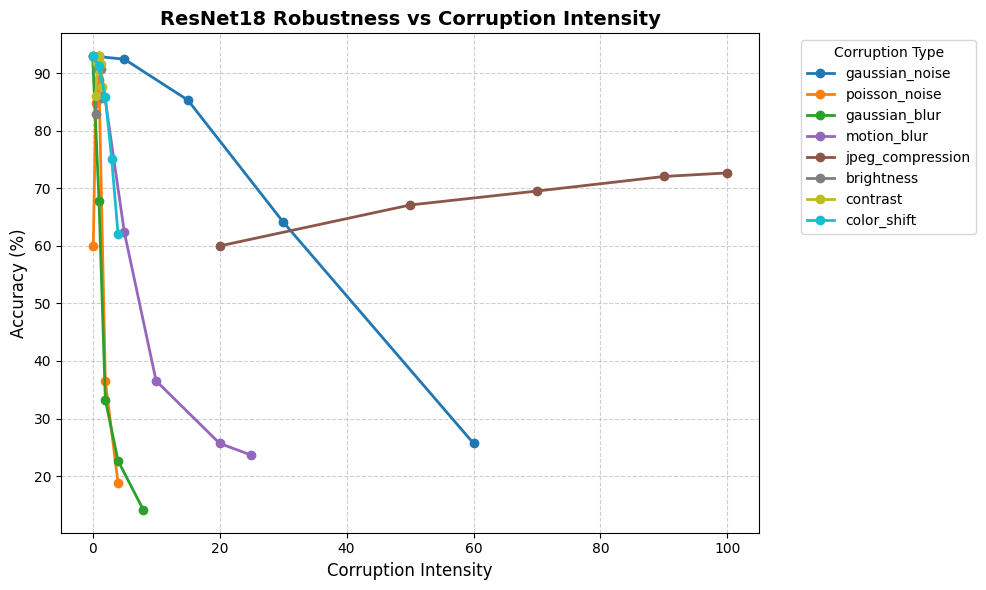

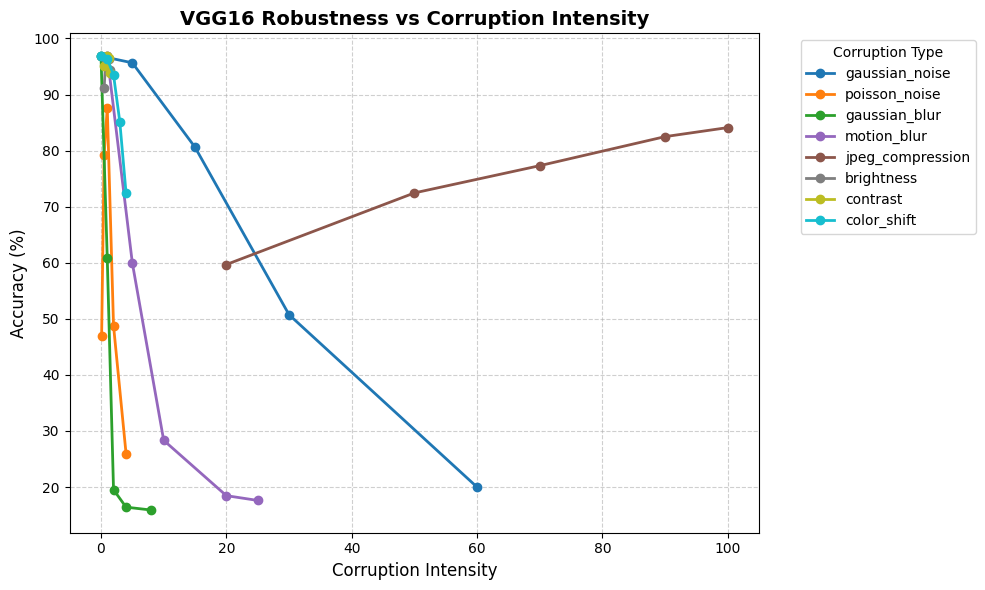

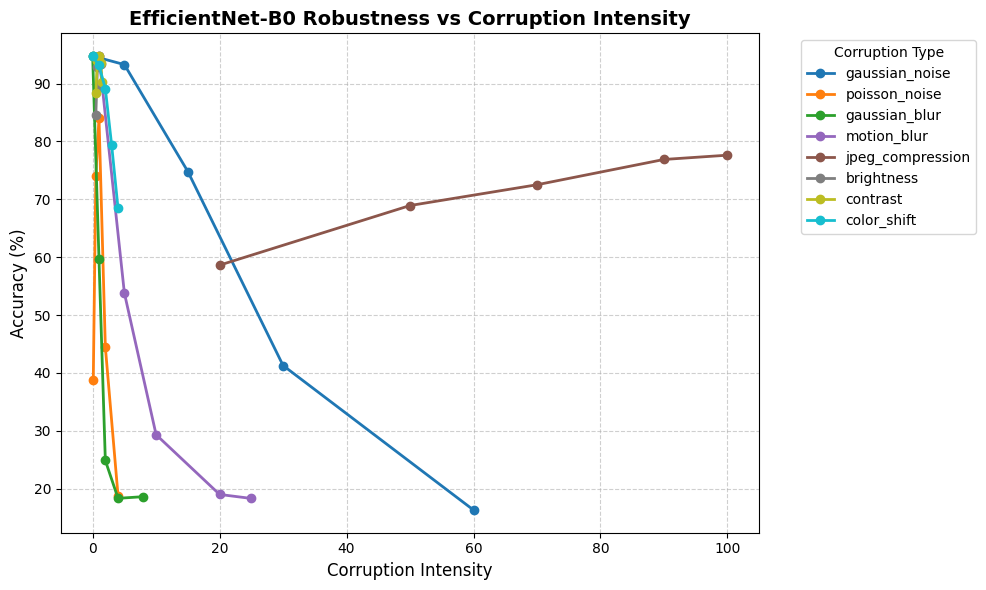

In [29]:
for model_name, robustness_results in all_model_results.items():
    plt.figure(figsize=(10,6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(robustness_results)))
    
    for (corr, (lvls, accs)), color in zip(robustness_results.items(), colors):
        x = list(range(len(lvls))) if isinstance(lvls[0], tuple) else lvls
        plt.plot(x, [a*100 for a in accs], marker='o', label=corr, color=color, linewidth=2, markersize=6)
    
    plt.title(f"{model_name} Robustness vs Corruption Intensity", fontsize=14, fontweight='bold')
    plt.xlabel("Corruption Intensity", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Corruption Type")
    plt.tight_layout()
    plt.show()
